# Timeseries analysis using LSTM - RNN

## Common imports and functions

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import datetime as dt
import calendar as cal
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

from IPython.display import display
pd.options.display.max_columns = 50

## Read the stocks historical prices

In [18]:
df = pd.read_csv('../dataset/5191.csv')
df['date'] = pd.to_datetime(df['date'])
df.info()
df.rename(index=str, columns={'price': 'close'}, inplace=True)
df.drop(['volume','change_percent'], axis=1, inplace=True)
df.sort_values(['date'], ascending=True, inplace=True)
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 7 columns):
date              910 non-null datetime64[ns]
price             910 non-null float64
open              910 non-null float64
high              910 non-null float64
low               910 non-null float64
volume            910 non-null object
change_percent    910 non-null object
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 49.8+ KB


,date,close,open,high,low
909,2015-01-02,1.600,1.620,1.620,1.600
908,2015-01-05,1.530,1.600,1.600,1.520
907,2015-01-06,1.500,1.530,1.530,1.470
906,2015-01-07,1.560,1.500,1.560,1.480
905,2015-01-08,1.670,1.560,1.670,1.560
904,2015-01-09,1.730,1.700,1.750,1.690
903,2015-01-12,1.700,1.720,1.720,1.700
902,2015-01-13,1.680,1.700,1.700,1.680
901,2015-01-14,1.600,1.680,1.680,1.590
900,2015-01-15,1.580,1.620,1.640,1.580


## Pattern over time

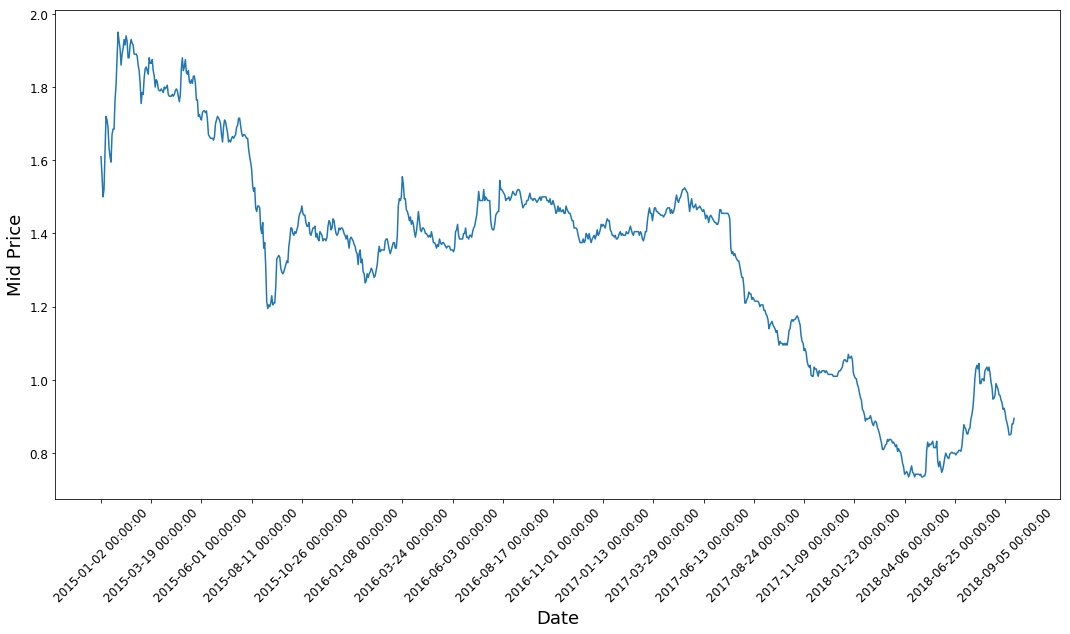

In [23]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['low']+df['high'])/2.0)
plt.xticks(range(0,df.shape[0],50),df['date'].loc[::50],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

## Split data into training set and a test set

In [76]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'high'].as_matrix()
low_prices = df.loc[:,'low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(mid_prices, test_size=0.2, random_state=42)
display(len(test_data))
display(len(train_data))
display(train_data)
display(test_data)

182

728

array([1.875 , 1.595 , 1.465 , 1.385 , 0.9825, 1.06  , 1.465 , 1.71  ,
       0.7475, 1.415 , 1.915 , 1.82  , 1.49  , 1.475 , 1.45  , 1.52  ,
       1.42  , 1.495 , 1.88  , 1.36  , 1.52  , 0.7925, 1.455 , 0.805 ,
       1.43  , 1.255 , 1.215 , 1.375 , 0.7425, 1.405 , 1.415 , 0.7775,
       0.8175, 0.765 , 0.8325, 1.41  , 1.4   , 1.375 , 1.48  , 1.435 ,
       1.055 , 1.325 , 1.69  , 1.01  , 1.46  , 1.385 , 1.52  , 1.73  ,
       1.46  , 1.04  , 1.42  , 1.45  , 1.01  , 1.0125, 1.055 , 0.965 ,
       1.505 , 1.5   , 1.465 , 1.045 , 1.41  , 0.945 , 1.47  , 1.4   ,
       0.8   , 1.35  , 1.44  , 1.5   , 0.8375, 1.49  , 1.395 , 1.155 ,
       1.4   , 1.39  , 1.495 , 1.435 , 1.165 , 1.415 , 1.78  , 1.61  ,
       1.495 , 1.495 , 1.42  , 1.435 , 0.8   , 1.665 , 1.375 , 1.47  ,
       1.425 , 1.475 , 1.22  , 1.175 , 1.505 , 1.5   , 1.49  , 1.47  ,
       1.21  , 1.46  , 1.515 , 1.49  , 0.735 , 1.82  , 0.795 , 1.29  ,
       1.385 , 0.735 , 1.775 , 1.665 , 0.75  , 0.92  , 1.69  , 1.31  ,
      

array([0.905 , 1.5   , 1.37  , 1.03  , 0.8375, 0.77  , 1.405 , 1.29  ,
       0.85  , 1.025 , 1.405 , 0.88  , 1.78  , 1.665 , 1.46  , 1.015 ,
       1.93  , 1.495 , 1.33  , 1.39  , 1.49  , 1.42  , 1.385 , 1.47  ,
       1.38  , 0.7425, 1.355 , 1.15  , 1.12  , 1.495 , 1.81  , 1.375 ,
       1.405 , 1.01  , 1.365 , 1.22  , 1.345 , 1.93  , 1.375 , 1.4   ,
       1.4   , 1.405 , 1.8   , 1.835 , 1.005 , 1.395 , 1.405 , 1.775 ,
       1.385 , 1.46  , 1.01  , 1.225 , 1.385 , 1.46  , 1.28  , 1.775 ,
       1.715 , 1.695 , 0.8225, 1.45  , 0.8075, 1.85  , 1.02  , 1.405 ,
       1.36  , 1.215 , 1.035 , 1.41  , 0.9475, 1.37  , 1.49  , 0.79  ,
       1.48  , 1.03  , 1.405 , 1.48  , 0.8025, 1.355 , 1.025 , 1.795 ,
       1.47  , 1.455 , 1.365 , 1.695 , 1.805 , 1.395 , 1.32  , 1.455 ,
       1.66  , 1.135 , 1.44  , 1.04  , 1.33  , 1.5   , 1.495 , 1.47  ,
       0.8325, 1.79  , 1.315 , 1.405 , 1.2   , 1.435 , 1.41  , 0.7425,
       1.36  , 1.445 , 0.8925, 1.455 , 1.02  , 1.465 , 1.415 , 1.36  ,
      

### Normalizing the data

In [79]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)
print(len(test_data))
print(len(train_data))

# Train the Scaler with training data and smooth data
smoothing_window_size = 100
for di in range(0,len(train_data),smoothing_window_size):
    # print('fit transform training data')
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])
    
# You normalize the last bit of remaining data
# scaler.fit(train_data[di+smoothing_window_size:,:])
# train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

# Reshape both train and test data
train_data = train_data.reshape(-1)
display(train_data)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)
display(test_data)

182
728


array([0.96588486, 0.72707889, 0.61620469, 0.54797441, 0.20469083,
       0.27078891, 0.61620469, 0.82515991, 0.00426439, 0.57356077,
       1.        , 0.91897655, 0.63752665, 0.62473348, 0.60341151,
       0.66311301, 0.57782516, 0.64179104, 0.97014925, 0.52665245,
       0.66311301, 0.04264392, 0.60767591, 0.0533049 , 0.58635394,
       0.43710021, 0.40298507, 0.53944563, 0.        , 0.56503198,
       0.57356077, 0.02985075, 0.06396588, 0.01918977, 0.07675906,
       0.56929638, 0.56076759, 0.53944563, 0.62899787, 0.59061834,
       0.26652452, 0.49680171, 0.80810235, 0.22814499, 0.6119403 ,
       0.54797441, 0.66311301, 0.84221748, 0.6119403 , 0.25373134,
       0.57782516, 0.60341151, 0.22814499, 0.23027719, 0.26652452,
       0.18976546, 0.65031983, 0.64605544, 0.61620469, 0.25799574,
       0.56929638, 0.17270789, 0.62046908, 0.56076759, 0.04904051,
       0.51812367, 0.59488273, 0.64605544, 0.08102345, 0.63752665,
       0.5565032 , 0.35181237, 0.56076759, 0.55223881, 0.64179

array([0.14541387, 0.67785235, 0.56152125, 0.25727069, 0.08501119,
       0.0246085 , 0.59284116, 0.48993289, 0.09619687, 0.25279642,
       0.59284116, 0.12304251, 0.92841163, 0.82550336, 0.64205817,
       0.24384787, 1.06263982, 0.67337808, 0.52572707, 0.57941834,
       0.6689038 , 0.60626398, 0.57494407, 0.65100671, 0.5704698 ,
       0.        , 0.54809843, 0.36465324, 0.33780761, 0.67337808,
       0.95525727, 0.56599553, 0.59284116, 0.2393736 , 0.55704698,
       0.42729306, 0.53914989, 1.06263982, 0.56599553, 0.58836689,
       0.58836689, 0.59284116, 0.94630872, 0.97762864, 0.23489933,
       0.58389262, 0.59284116, 0.92393736, 0.57494407, 0.64205817,
       0.2393736 , 0.43176734, 0.57494407, 0.64205817, 0.48098434,
       0.92393736, 0.87024609, 0.85234899, 0.07158837, 0.63310962,
       0.05816555, 0.99105145, 0.24832215, 0.59284116, 0.55257271,
       0.42281879, 0.26174497, 0.59731544, 0.18344519, 0.56152125,
       0.6689038 , 0.04250559, 0.65995526, 0.25727069, 0.59284

In [71]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(len(train_data)):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

### One step ahead prediction via averaging